## Mode d'emploi
___
### 1. Enregistrement des données
Afin d'enregistrer un sujet sur l'expérience, il suffit de suivre la démarche ci-dessous :  
1. Ouvrir le fichier ``config.ini`` et entrer le nom du sujet, en minuscule et sans accent, à la place du nom du sujet précédent -> ``subject = <nom du sujet>``
2. Ouvrir le fichier ``stochastic_breakout.py`` dans un éditeur Python (j'utilise ``Spyder.exe`` pour ma part).  
3. Choisir quel set de niveaux on veut utiliser (vers le début du programme on peut facilement trouver la ligne permettant de modifier le set de niveaux avec les explications qui vont avec)  
4. Brancher ``TheEyeTribe``
5. Procéder au calibrage à l'aide de l'application native ``EyeTribe UI``
6. Exécuter le programme du jeu (F5)
7. Attendre que le sujet ait fini !  

### 2. Analyse des données
Afin d'exécuter ce programme d'analyse de données, il faut tout d'abord exécuter la cellule ci-dessous. Celle-ci permet de charger les modules utilisés dans les cellules suivantes. Il faut ensuite exécuter la seconde cellule, qui permet de récupérer les données des fichers data, puis la troisième cellule, qui permet de faire connaître la répartition des briques dans les niveaux au programme d'analyse.  

In [2]:
from __future__ import division, print_function
import os, glob, matplotlib.pyplot as plt, numpy as np, pandas as pd, math, re, itertools
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=6, suppress=True)
#%matplotlib notebook
%matplotlib inline

La cellule ci-dessous permet de recueillir les données contenues dans les fichiers .csv  
Elle permet également de créer les listes ``subjects`` et ``levels`` contenant respectivement les noms de tous les sujets ainsi que les niveaux sur lesquels ils sont passé (dans notre cas de 6 niveaux ``levels = [lvl1, lvl2, lvl3, lvl4, lvl5, lvl6]``)  
Et enfin, cette cellule permet le calcul des gradients et donc la détection des rebonds

In [3]:
df, grad = {}, {}
duration, subjects, levels = [], [], []

# Lecture des fichiers données
for file in glob.glob(os.path.join('..', 'datadir', 'pilot', '*csv')):
    df_ = pd.read_csv(file, '\t')

    _, fname = os.path.split(file)
    fname, ext = fname.split('.')
    date, time, _, level, subj = fname.split('_')

    if subj not in subjects:
        subjects.append(subj)
    if level not in levels:
        levels.append(level)

    try:
        df[subj][level] = {}
        grad[subj][level] = {}
    except:
        df[subj] = {}
        df[subj][level] = {}
        grad[subj] = {}
        grad[subj][level] = {}

    # Création des Dataframes contenant les données afin de pouvoir travailler dessus
    for axis in ['T', 'X', 'Y']:
        for obj in ['gaze', 'ball', 'paddle']:
            df[subj][level][axis+obj] = df_[axis+obj]

    N_start, N_stop = 0, int((df[subj][level]['Tgaze'][len(df[subj][level]['Tgaze'])-1] - df[subj][level]['Tgaze'][0])*30)

    # Détection des changements de signe du gradient
    grad_, t_rebound_, value_old, value_older = [], [], 0, 0
    for k, value in enumerate(np.gradient(df[subj][level]['Yball'])[N_start:N_stop]):   
        # CETTE PARTIE PERMET  DE DETECTER UN REBOND FRAPPANT LA BRIQUE PAR LE BAS
        if value > 0 and  value_older < 0:
            grad_.append(k)
        # CETTE PARTIE PERMET  DE DETECTER UN REBOND FRAPPANT LA BRIQUE PAR LE HAUT
        """if value < 0 and  value_older > 0:
            grad_.append(k)"""
                
        value_older = value_old
        value_old = value

    grad[subj][level] = grad_

La cellule ci-dessous contient les matrices décrivant les niveaux (matrices contenues dans le fichier ``config.ini``).  
Avoir ces matrices dans l'analyse de données permet la détection des couleurs des briques.

In [4]:
lvls_mix = [[[1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1, 1, 1, 5, 1],
         [1, 5, 1, 5, 1, 5, 5, 5, 5],
         [5, 5, 1, 5, 1, 5, 1, 5, 5],
         [5, 1, 1, 5, 0, 1, 5, 5, 1],
         [5, 1, 5, 1, 5, 1, 1, 1, 1],
         [5, 1, 1, 5, 5, 5, 5, 1, 1],
         [5, 1, 5, 1, 5, 5, 5, 1, 1],
         [5, 5, 5, 5, 1, 1, 1, 5, 1],
         [1, 1, 5, 5, 1, 5, 5, 1, 5]],

        [[5, 1, 5, 5, 1, 5, 1, 3, 1],
         [1, 3, 5, 3, 5, 3, 3, 3, 3],
         [3, 3, 1, 3, 1, 3, 5, 3, 3],
         [3, 1, 5, 3, 0, 1, 3, 3, 1],
         [3, 5, 3, 1, 3, 1, 1, 5, 1],
         [3, 1, 5, 3, 3, 3, 3, 1, 5],
         [3, 5, 3, 5, 3, 3, 3, 1, 5],
         [3, 3, 3, 3, 5, 5, 1, 3, 5],
         [1, 5, 3, 3, 5, 3, 3, 1, 3]],

        [[2, 2, 2, 2, 2, 2, 2, 4, 2],
         [2, 4, 2, 4, 2, 4, 4, 4, 4],
         [4, 4, 2, 4, 2, 4, 2, 4, 4],
         [4, 2, 2, 4, 0, 2, 4, 4, 2],
         [4, 2, 4, 2, 4, 2, 2, 2, 2],
         [4, 2, 2, 4, 4, 4, 4, 2, 2],
         [4, 2, 4, 2, 4, 4, 4, 2, 2],
         [4, 4, 4, 4, 2, 2, 2, 4, 2],
         [2, 2, 4, 4, 2, 4, 4, 2, 4]],

        [[2, 1, 2, 2, 1, 2, 1, 4, 1],
         [1, 3, 2, 4, 2, 4, 3, 4, 4],
         [3, 3, 1, 4, 1, 3, 2, 4, 3],
         [3, 1, 2, 3, 0, 1, 3, 3, 1],
         [4, 2, 3, 1, 4, 1, 1, 2, 1],
         [4, 1, 2, 4, 3, 3, 4, 1, 2],
         [3, 2, 3, 2, 3, 4, 3, 1, 2],
         [4, 3, 4, 4, 2, 2, 1, 3, 2],
         [1, 2, 4, 4, 2, 4, 4, 1, 3]],

        [[2, 1, 2, 2, 2, 2, 1, 5, 1],
         [1, 4, 3, 5, 3, 5, 3, 5, 4],
         [4, 3, 1, 5, 1, 3, 3, 4, 3],
         [4, 2, 3, 4, 0, 1, 4, 4, 2],
         [5, 2, 3, 1, 5, 1, 2, 3, 1],
         [5, 1, 3, 5, 4, 3, 5, 1, 2],
         [3, 2, 4, 2, 3, 5, 4, 1, 3],
         [5, 4, 4, 5, 3, 2, 1, 4, 2],
         [1, 2, 5, 5, 2, 4, 5, 1, 4]]]

lvls_mono = [[[0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 1, 0, 0, 0, 1, 1, 1]],

             [[0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [2, 2, 2, 2, 2, 2, 2, 2, 2],
              [2, 2, 2, 2, 2, 2, 2, 2, 2],
              [2, 2, 2, 2, 2, 2, 2, 2, 2],
              [2, 2, 2, 2, 2, 2, 2, 2, 2],
              [2, 2, 2, 2, 2, 2, 2, 2, 2],
              [2, 2, 2, 2, 2, 2, 2, 2, 2],
              [2, 2, 2, 0, 0, 0, 2, 2, 2]],

             [[0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [3, 3, 3, 3, 3, 3, 3, 3, 3],
              [3, 3, 3, 3, 3, 3, 3, 3, 3],
              [3, 3, 3, 3, 3, 3, 3, 3, 3],
              [3, 3, 3, 3, 3, 3, 3, 3, 3],
              [3, 3, 3, 3, 3, 3, 3, 3, 3],
              [3, 3, 3, 3, 3, 3, 3, 3, 3],
              [3, 3, 3, 0, 0, 0, 3, 3, 3]],

             [[0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [4, 4, 4, 4, 4, 4, 4, 4, 4],
              [4, 4, 4, 4, 4, 4, 4, 4, 4],
              [4, 4, 4, 4, 4, 4, 4, 4, 4],
              [4, 4, 4, 4, 4, 4, 4, 4, 4],
              [4, 4, 4, 4, 4, 4, 4, 4, 4],
              [4, 4, 4, 4, 4, 4, 4, 4, 4],
              [4, 4, 4, 0, 0, 0, 4, 4, 4]],

             [[0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [5, 5, 5, 5, 5, 5, 5, 5, 5],
              [5, 5, 5, 5, 5, 5, 5, 5, 5],
              [5, 5, 5, 5, 5, 5, 5, 5, 5],
              [5, 5, 5, 5, 5, 5, 5, 5, 5],
              [5, 5, 5, 5, 5, 5, 5, 5, 5],
              [5, 5, 5, 5, 5, 5, 5, 5, 5],
              [5, 5, 5, 0, 0, 0, 5, 5, 5]],

             [[2, 1, 2, 2, 2, 2, 1, 5, 1],
              [1, 4, 3, 5, 3, 5, 3, 5, 4],
              [4, 3, 1, 5, 1, 3, 3, 4, 3],
              [4, 2, 3, 4, 0, 1, 4, 4, 2],
              [5, 2, 3, 1, 5, 1, 2, 3, 1],
              [5, 1, 3, 5, 4, 3, 5, 1, 2],
              [3, 2, 4, 2, 3, 5, 4, 1, 3],
              [5, 4, 4, 5, 3, 2, 1, 4, 2],
              [1, 2, 5, 5, 2, 4, 5, 1, 4],
              [0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0]]]

La cellule ci-dessous permet la détection des couleurs des briques, le calcul des temps de saccade ainsi que des distances impact-regard.

In [5]:
# deltav correspond à la fenêtre temporelle centrée sur le rebond dans laquelle vont avoir lieu nos calculs
deltav = 10000
t_mean, lvl, t_sacc, t_rebound, p, t_mean_, lvl_sep, separation_ = {}, {}, {}, {}, {}, [], {}, {}
separation, time, p_, t_rebound_ = {}, {}, {}, {}
for subj in subjects:
    print("Subject: ", subj)
    t_mean[subj], lvl[subj], p[subj], t_sacc[subj], t_rebound[subj], lvl_sep[subj] = [], [], [], [], [], []
    separation[subj], time[subj], separation_[subj], p_[subj], t_rebound_[subj] = {}, {}, [], [], []

    for level in levels:
        separation[subj][level], time[subj][level] = [], []

        print(level)
        lvl_sep[subj].append(df[subj][level]['Tgaze'][len(df[subj][level]['Tgaze'])-1] - df[subj]['lvl1']['Tgaze'][0])
        for v in grad[subj][level]:
            if df[subj][level]['Yball'][v] > 61:
                distance = (df[subj][level]['Ygaze'][v] - df[subj][level]['Yball'][v])**2 + (df[subj][level]['Xgaze'][v] - df[subj][level]['Xball'][v])**2
                distance = np.sqrt(distance)

                distance_ = (df[subj][level]['Ygaze'][v-0] - df[subj][level]['Yball'][v])**2 + (df[subj][level]['Xgaze'][v-0] - df[subj][level]['Xball'][v])**2
                distance_ = np.sqrt(distance_)
                #print(distance_)
                separation[subj][level].append(distance_)
                if subj in ['remi', 'valerie', 'jade', 'thys', 'bruno']:
                    for x, y in itertools.product(range(9), range(11)):
                        if 41+x*139 <= df[subj][level]['Xball'][v] < 180+x*139 and 38+y*45 <= df[subj][level]['Yball'][v] < 83+y*45:
                            p_[subj].append(lvls_mono[int(re.findall(r'\d+', level)[0]) - 1][y][x])
                            t_rebound_[subj].append(df[subj][level]['Tgaze'][v])
                            separation_[subj].append(distance_)

                time[subj][level].append(df[subj][level]['Tgaze'][v]-df[subj][level]['Tgaze'][0])

                if distance < 200:
                    i = v-1
                    dist = (df[subj][level]['Ygaze'][v:v+deltav] - df[subj][level]['Yball'][v])**2 + (df[subj][level]['Xgaze'][v:v+deltav] - df[subj][level]['Xball'][v])**2
                    dist = np.sqrt(dist)
                    derivate = np.diff(dist)
                    if len(dist) != len(derivate):
                        derivate = np.append(derivate, np.nan)
                    for d in dist:
                        i += 1
                        if derivate[i-v] > 30:
                            print(df[subj][level]['Xball'][v], df[subj][level]['Yball'][v])
                            
                            """Niveaux Mixtes"""
                            if subj in ['juliette', 'elisa', 'maxime']:
                                for x, y in itertools.product(range(9), range(9)):
                                    if 41+x*139 <= df[subj][level]['Xball'][v] < 180+x*139 and 38+y*45 <= df[subj][level]['Yball'][v] < 83+y*45:
                                        p[subj].append(lvls_mix[int(re.findall(r'\d+', level)[0]) - 1][y][x])
                                        t_sacc[subj].append(df[subj][level]['Tgaze'][i]-df[subj][level]['Tgaze'][v])
                                        #print(lvls_mix[int(re.findall(r'\d+', level)[0]) - 1][y][x])
                                        t_rebound[subj].append(df[subj][level]['Tgaze'][v])

                            """Niveaux Monochromatiques"""
                            if subj in ['remi', 'valerie', 'jade', 'thys', 'bruno']:
                                for x, y in itertools.product(range(9), range(11)):
                                    if 41+x*139 <= df[subj][level]['Xball'][v] < 180+x*139 and 38+y*45 <= df[subj][level]['Yball'][v] < 83+y*45:
                                        p[subj].append(lvls_mono[int(re.findall(r'\d+', level)[0]) - 1][y][x])
                                        t_sacc[subj].append(df[subj][level]['Tgaze'][i]-df[subj][level]['Tgaze'][v])
                                        print(lvls_mono[int(re.findall(r'\d+', level)[0]) - 1][y][x])
                                        t_rebound[subj].append(df[subj][level]['Tgaze'][v])
                            break

        if np.std(t_sacc[subj]) < 10/10*np.mean(t_sacc[subj]):
            t_mean[subj].append(np.mean(t_sacc[subj]))
            t_mean_.append(np.mean(t_sacc[subj]))
            lvl[subj].append(re.findall(r'\d+', level)[0])
            print(np.mean(t_sacc[subj]), '+/-', np.std(t_sacc[subj]))

print(lvl)

Subject:  juliette
lvl1
515.0 438.0
370.0 436.0
121.0 434.0
382.0 392.0
367.0 348.0
220.0 440.0
203.0 343.0
342.0 303.0
193.0 258.0
383.0 118.0
107.0 386.0
59.0 345.0
104.0 304.0
226.0 207.0
200.0 165.0
476.0 342.0
624.0 432.0
631.0 387.0
71.0 253.0
778.0 390.0
1032.0 436.0
1027.0 393.0
1053.0 342.0
1197.0 439.0
1085.0 298.0
1061.0 258.0
1233.0 392.0
751.0 122.0
61.0 212.0
108.0 167.0
76.0 123.0
77.0 71.0
807.0 72.0
1180.0 346.0
1071.0 213.0
1042.0 118.0
1165.0 304.0
1231.0 255.0
0.365631617998 +/- 0.170263798545
lvl2
817.0 388.0
900.0 123.0
1080.0 252.0
1060.0 214.0
797.0 345.0
1164.0 393.0
838.0 135.0
821.0 297.0
737.0 122.0
756.0 75.0
586.0 284.0
609.0 251.0
684.0 161.0
1024.0 169.0
522.0 296.0
473.0 210.0
487.0 161.0
497.0 123.0
104.0 435.0
398.0 393.0
357.0 342.0
169.0 354.0
221.0 438.0
349.0 301.0
1227.0 343.0
1165.0 301.0
1213.0 252.0
420.0 253.0
341.0 211.0
102.0 386.0
222.0 74.0
78.0 344.0
495.0 74.0
1229.0 214.0
1241.0 163.0
1147.0 121.0
1210.0 79.0
66.0 78.0
0.344105303288 +

La cellule ci-dessous trace l'évolution des distances impact-regard pour chaque sujet (considéré) et pour chaque niveau de jeux.

C:\Users\Syht\Documents\Stage_LNC\Python\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


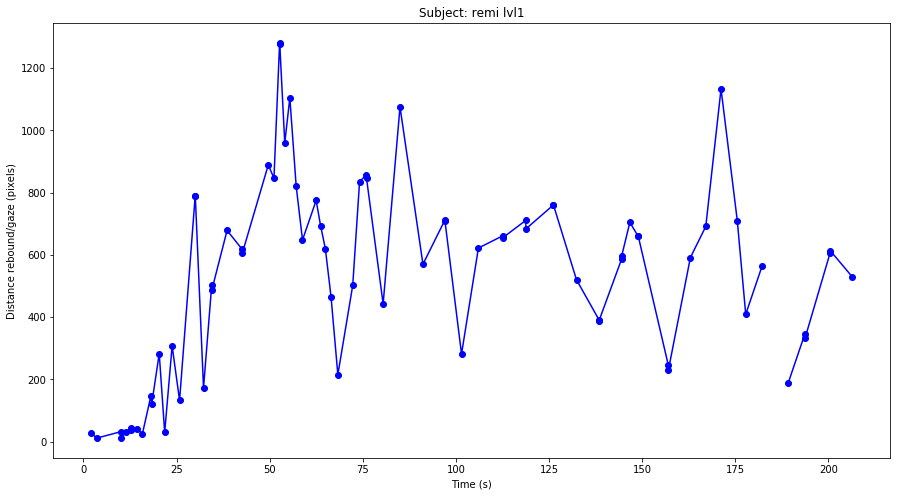

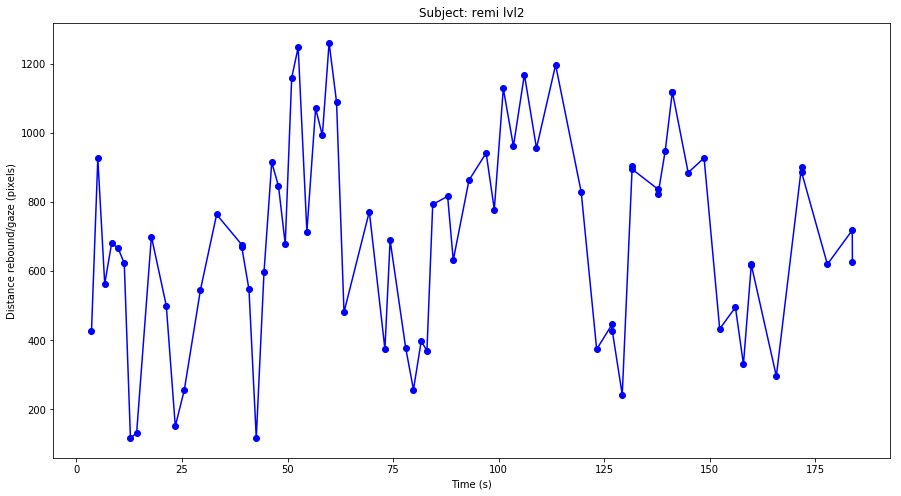

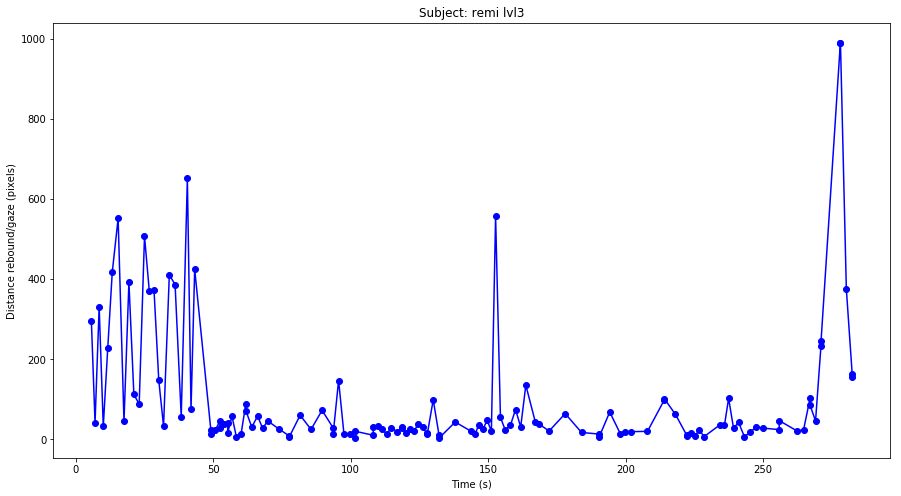

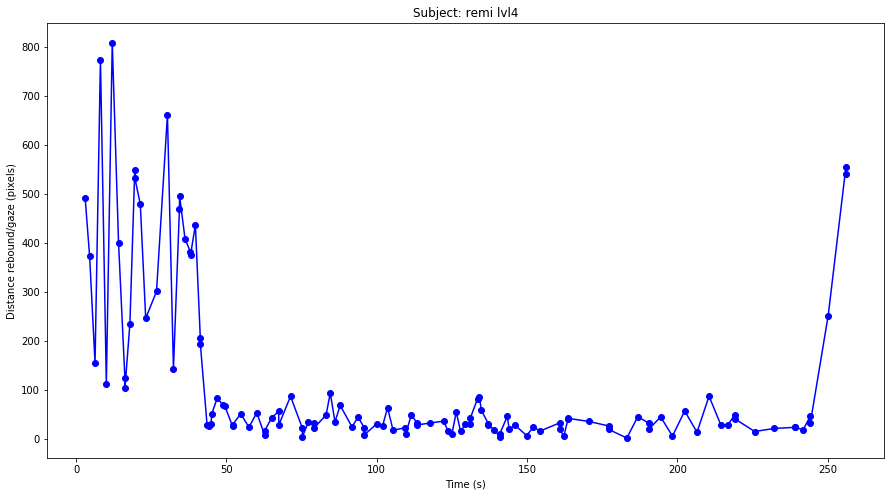

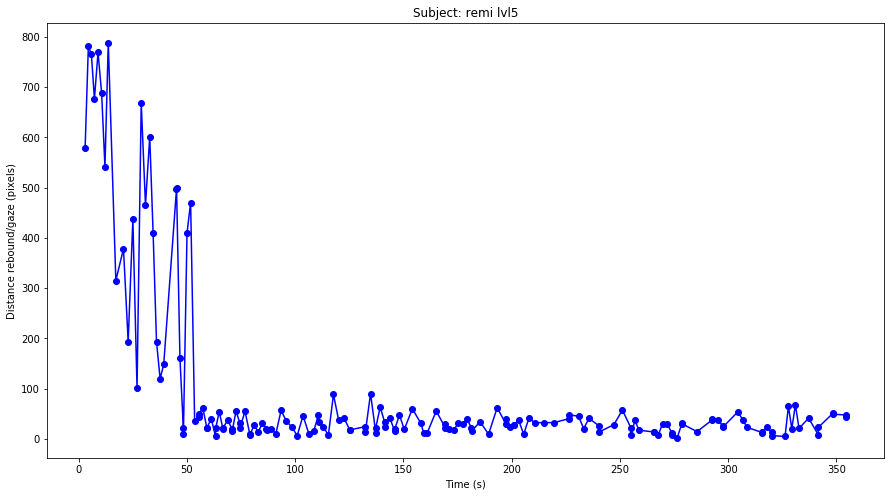

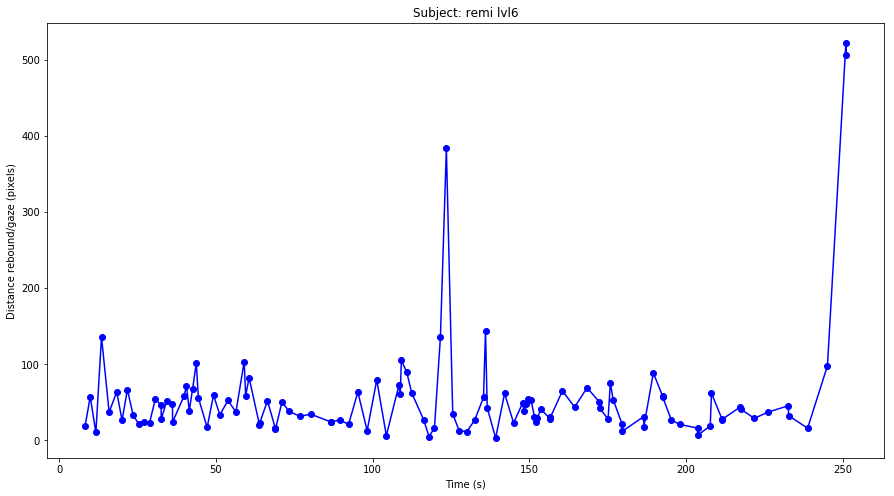

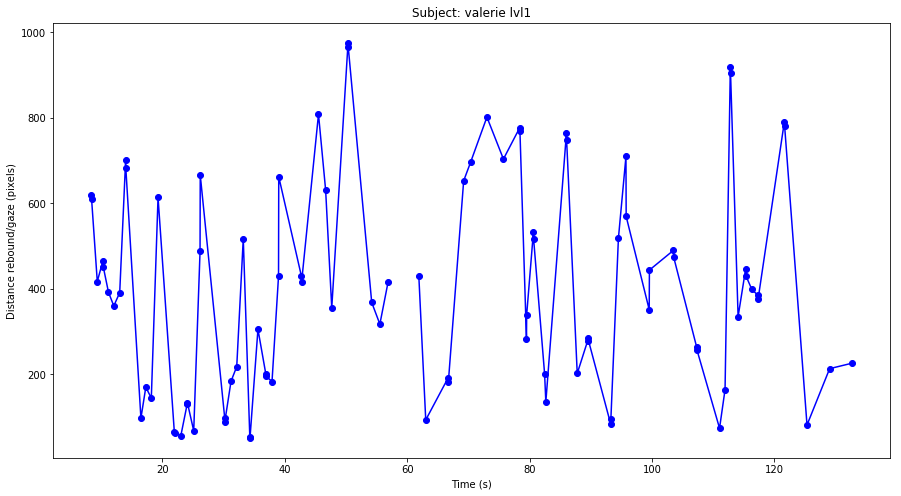

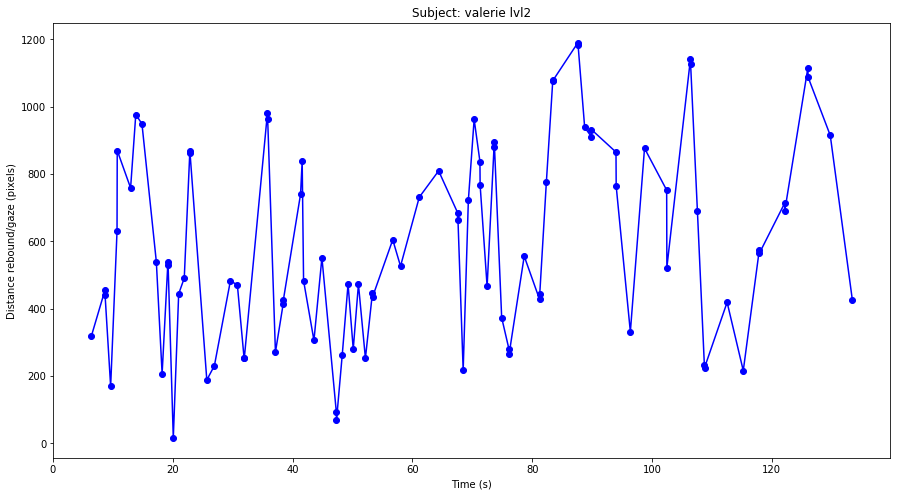

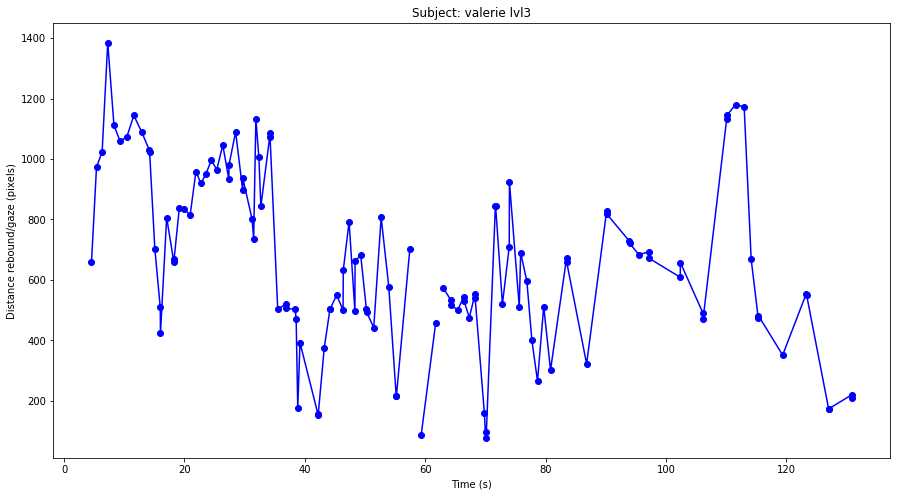

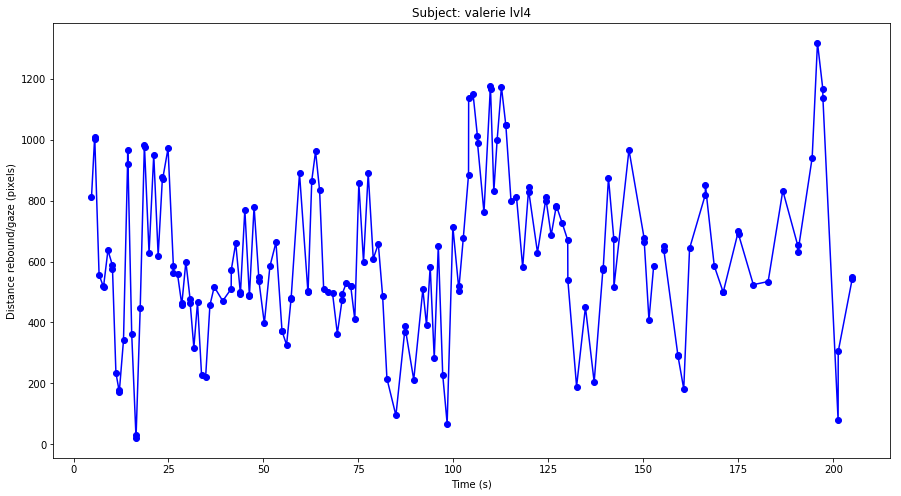

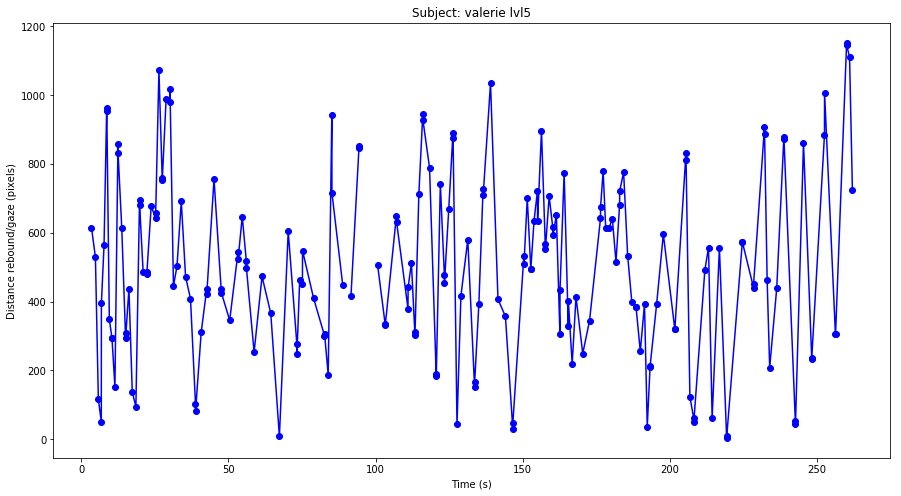

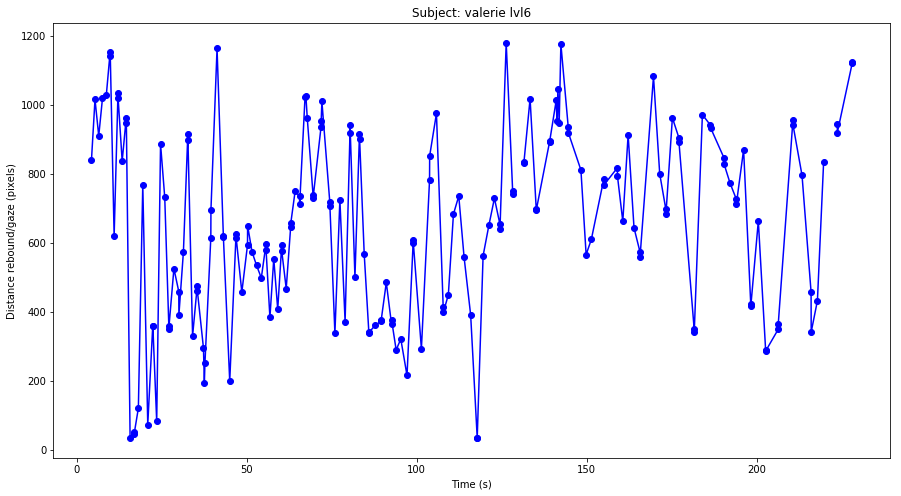

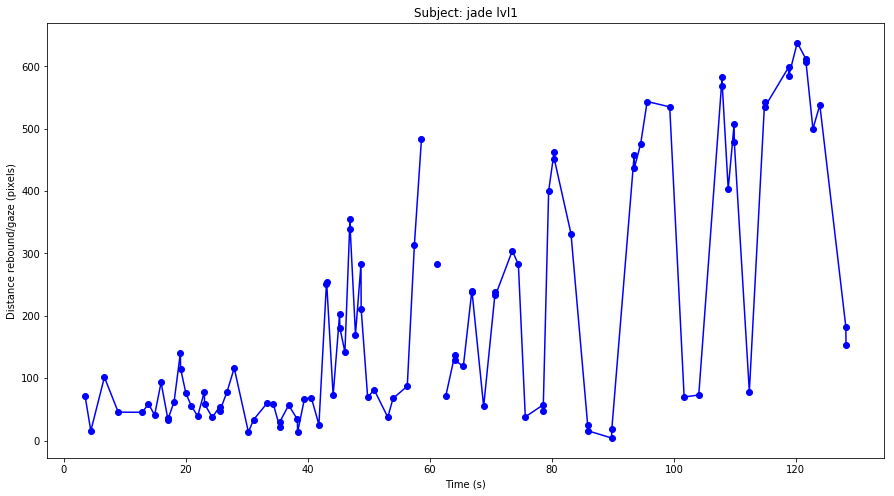

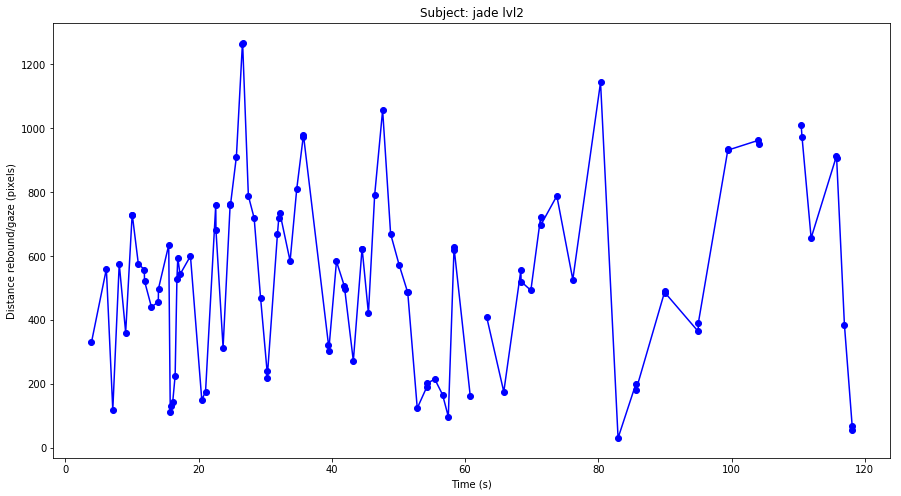

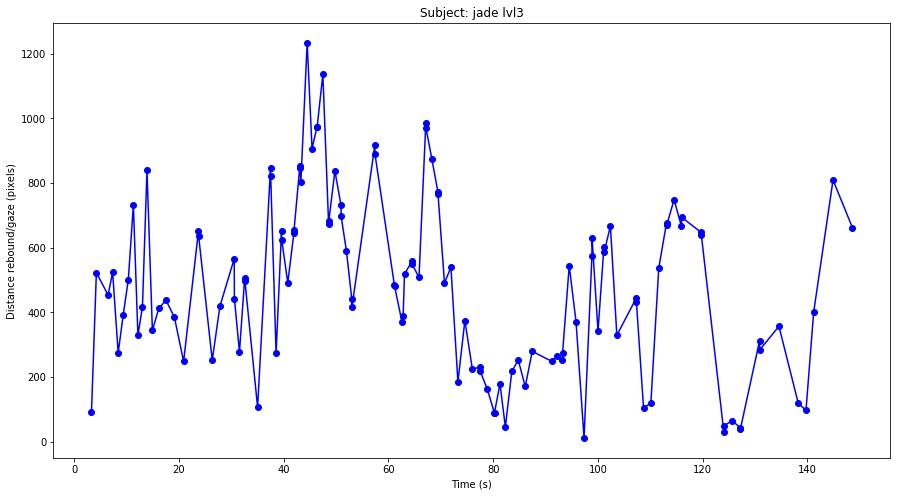

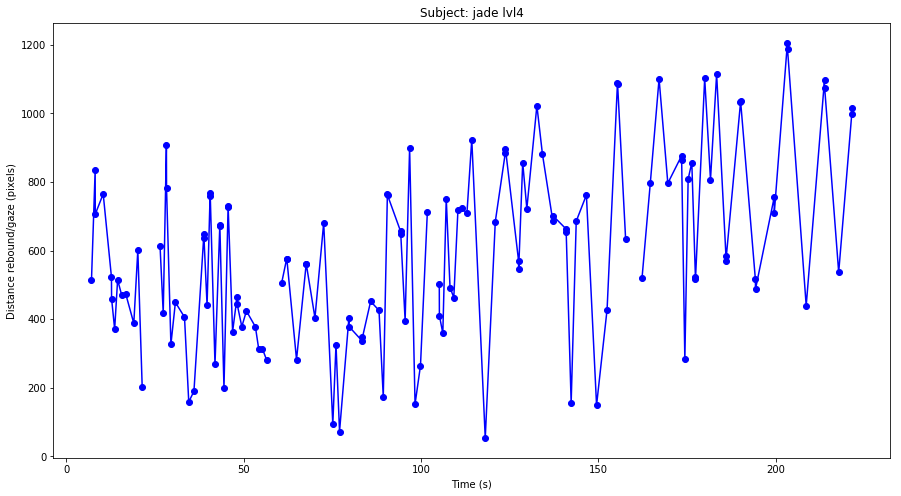

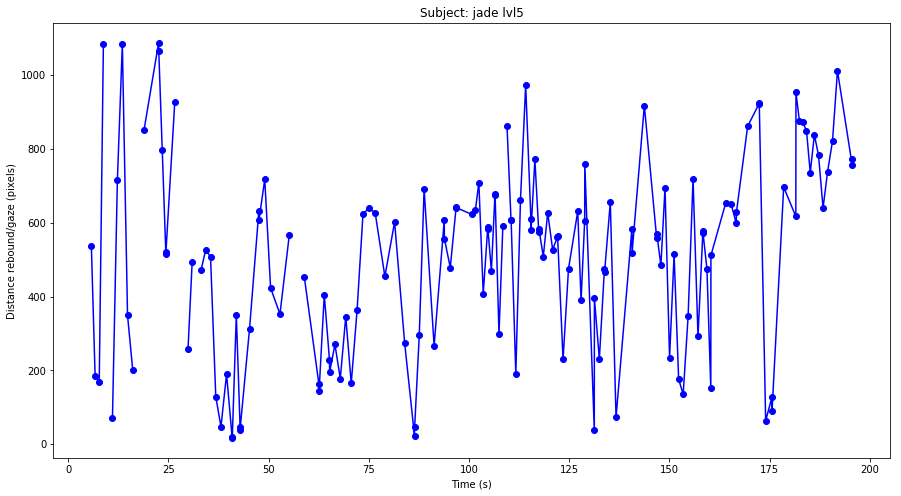

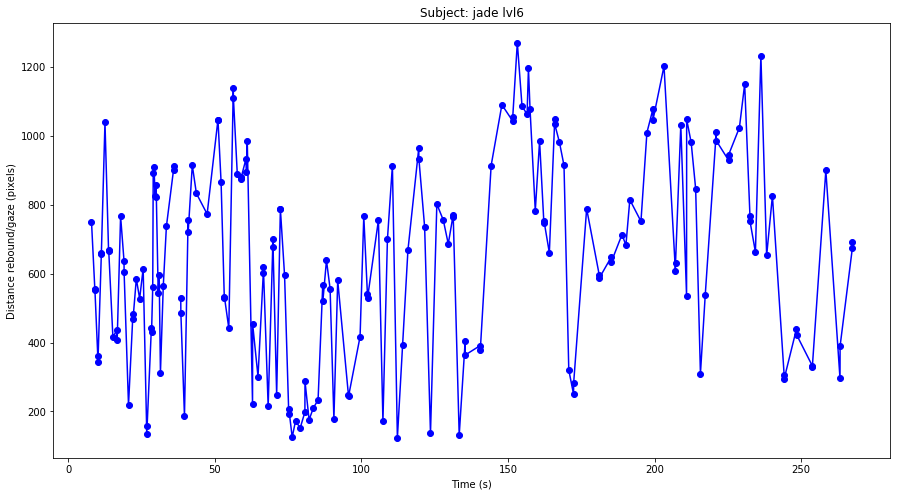

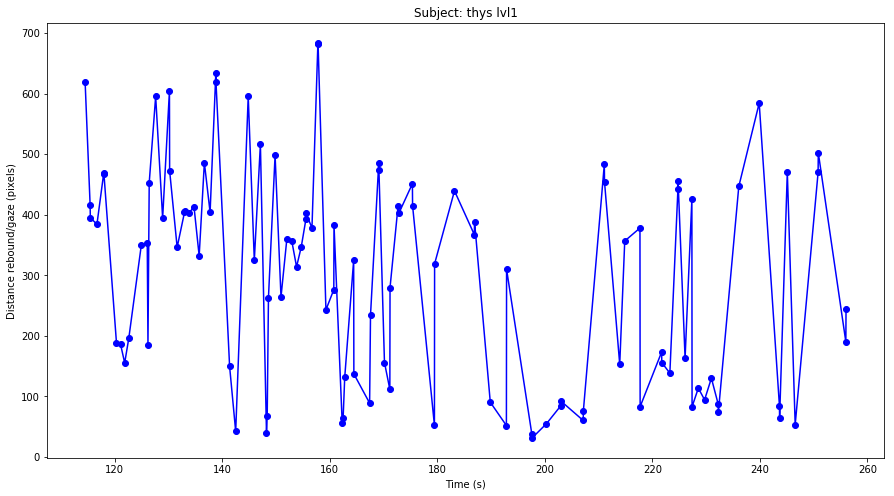

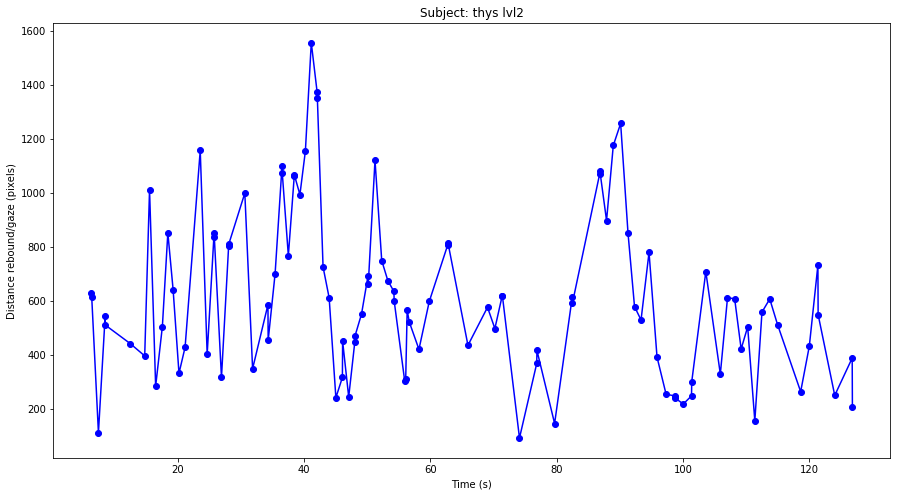

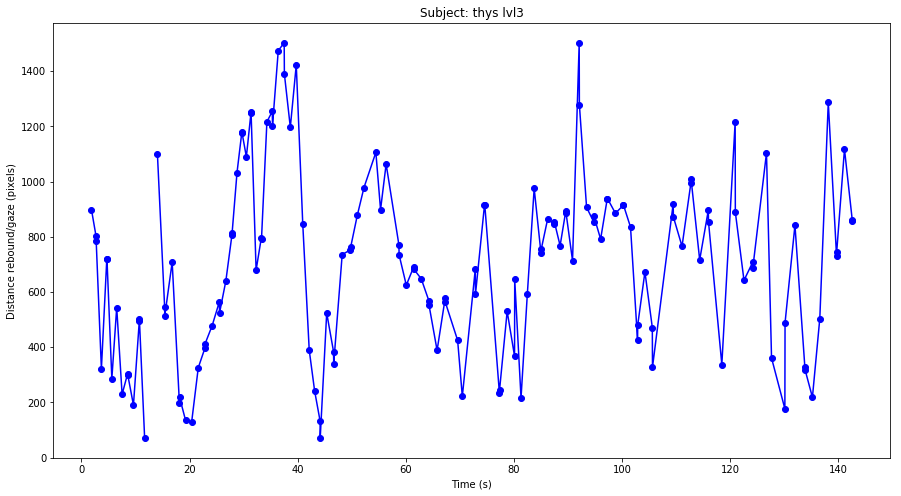

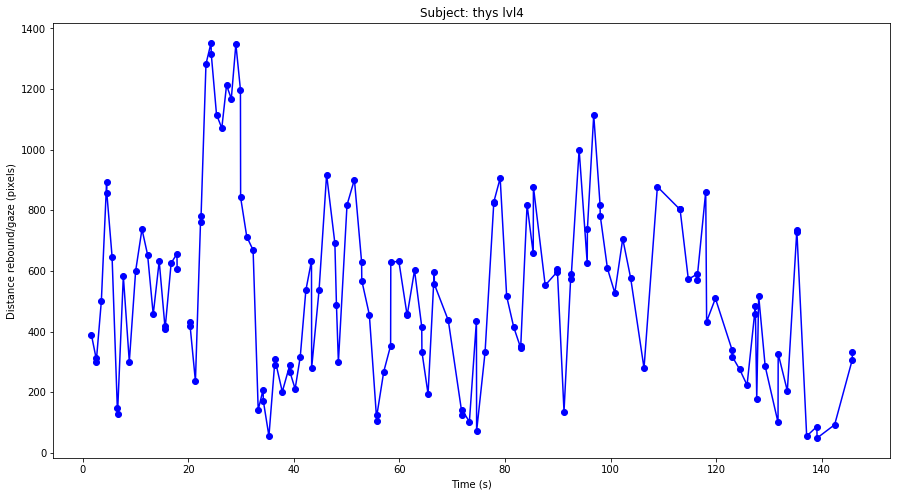

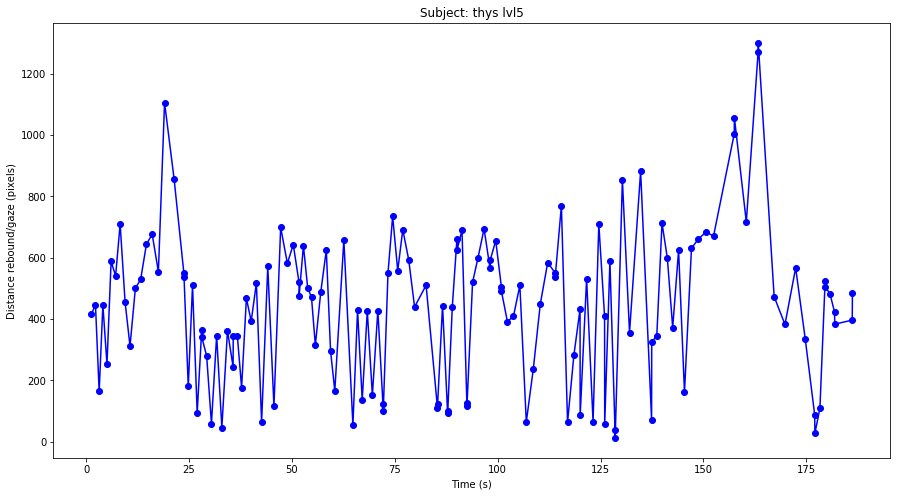

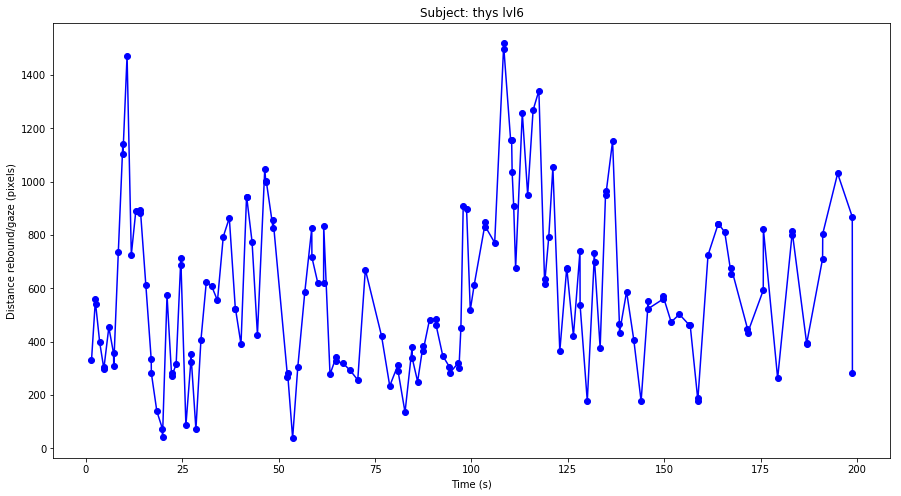

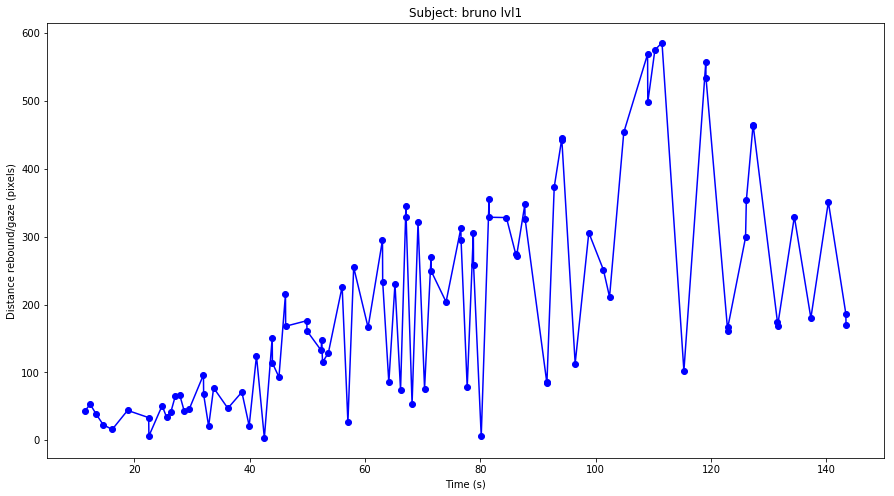

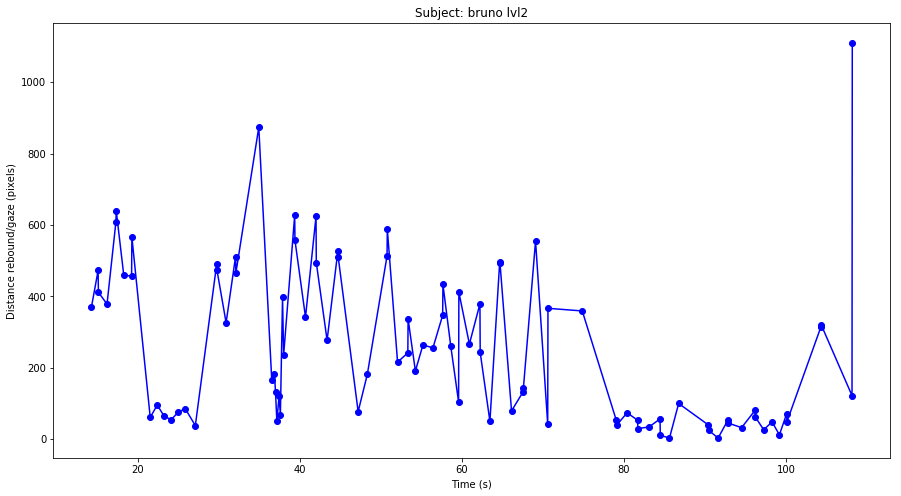

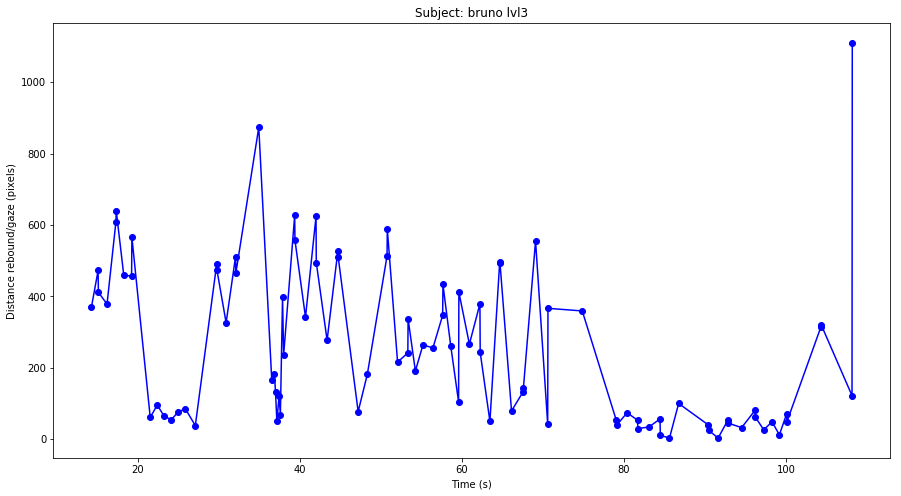

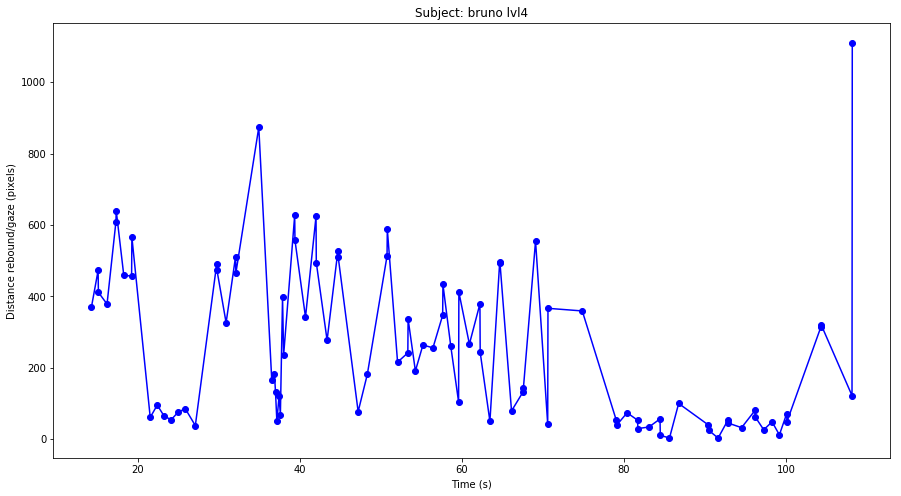

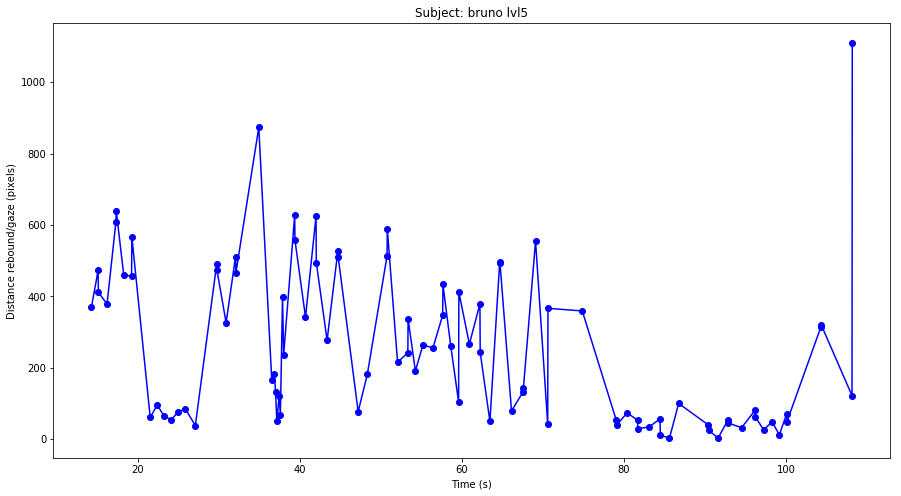

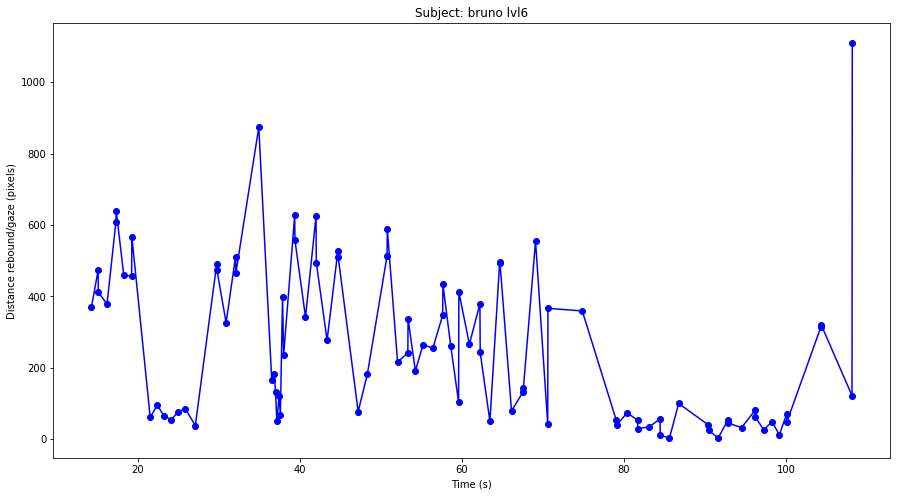

In [16]:
for subj in subjects:
    for level in levels:
        # Sujets considérés
        if subj in ['remi', 'valerie', 'jade', 'thys', 'bruno']:
            fig, ax = plt.subplots(figsize=(15,8))
            ax.plot(time[subj][level], separation[subj][level], 'bo-')
            ax.set_title('Subject: ' + subj + ' ' + level)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Distance rebound/gaze (pixels)')

La cellule ci-dessous trace l'évolution des distances impact-regard au cours des six niveaux renseignée de la couleur de brique correspondante.

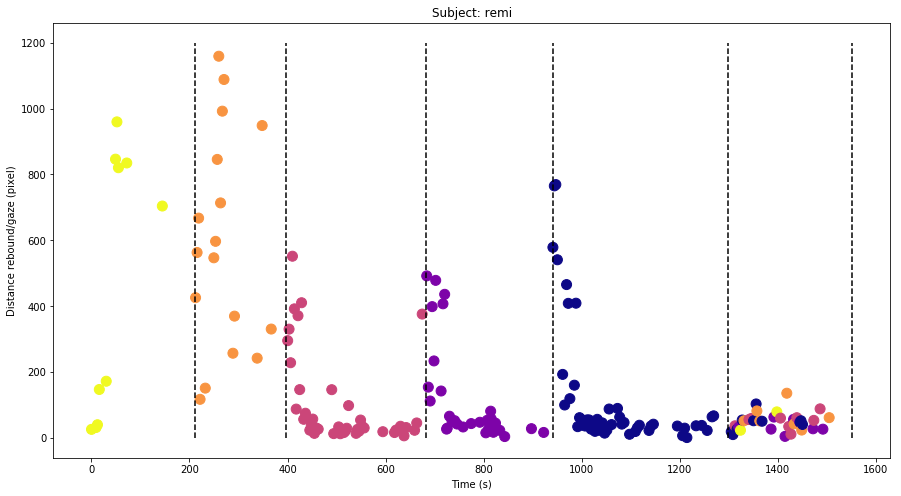

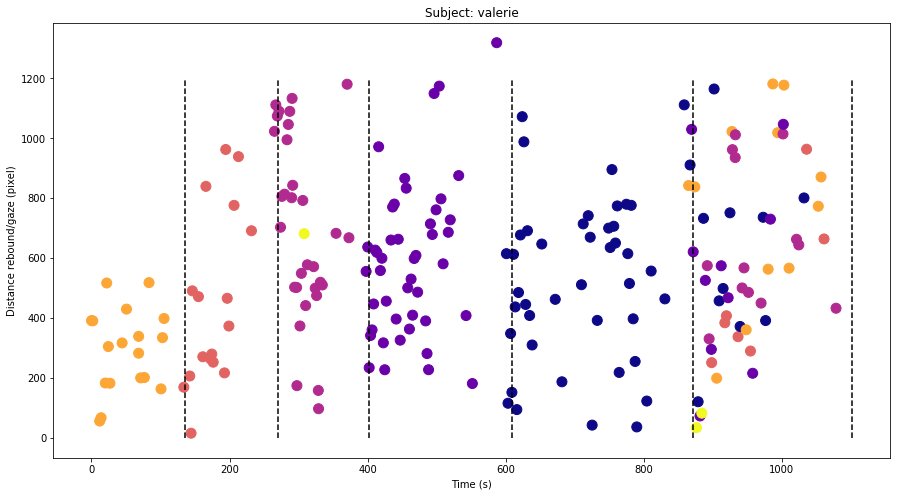

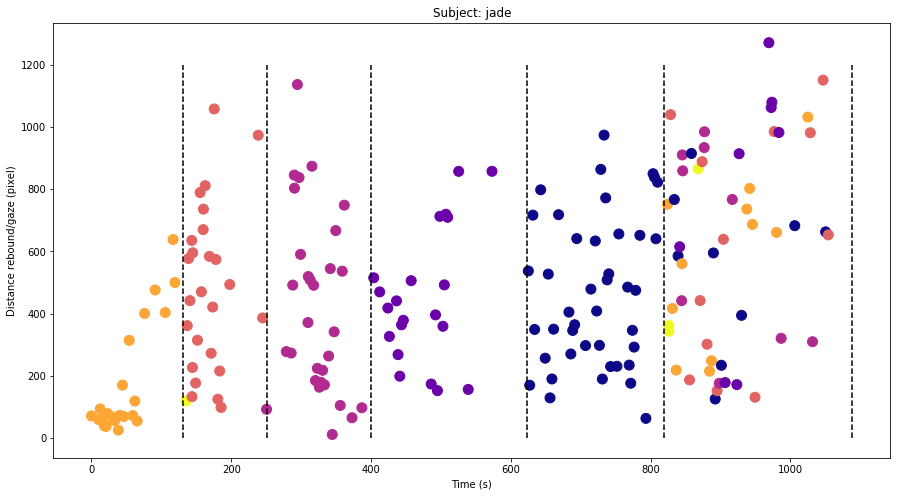

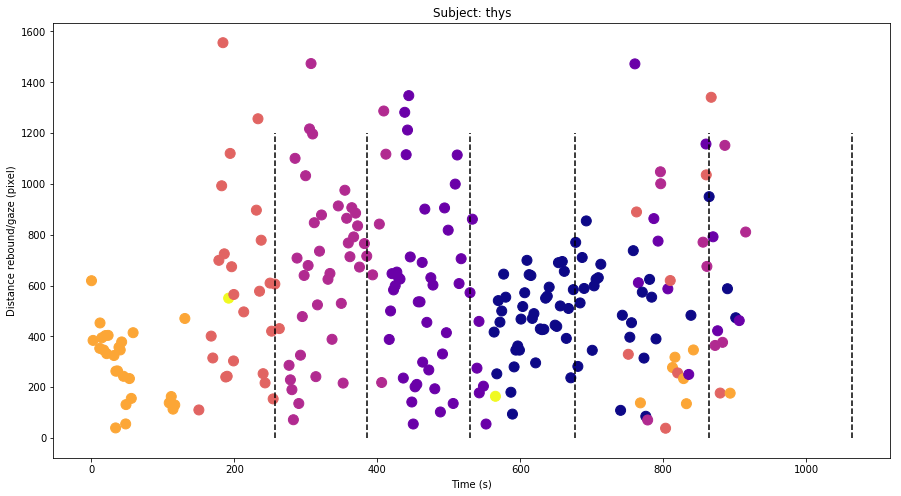

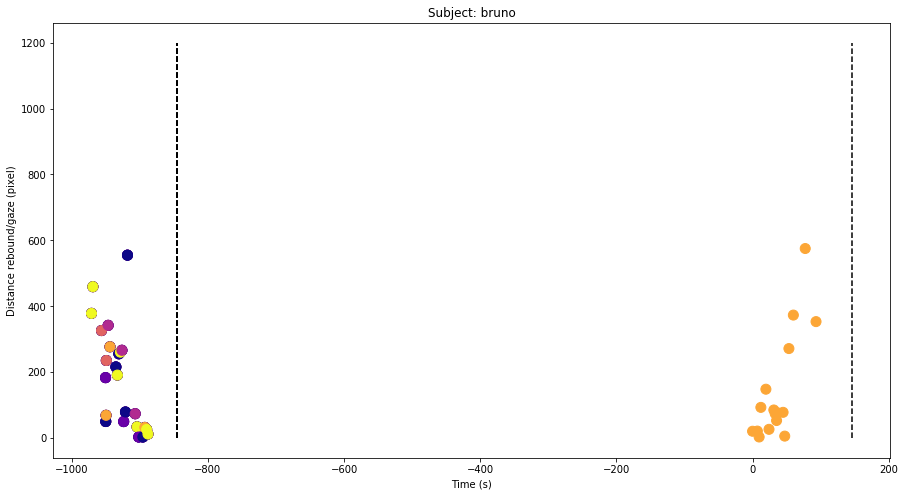

In [12]:
for subj in subjects:
    # Sujets considérés
    if subj in ['remi', 'valerie', 'jade', 'thys', 'bruno']:
        fig, ax = plt.subplots(figsize=(15,8))
        ax.scatter(t_rebound_[subj]-t_rebound_[subj][0], separation_[subj], c=p_[subj], s=100, cmap='plasma_r')
        for sep in lvl_sep[subj]:
            ax.plot([sep, sep], [0, 1200], 'k--')
        ax.set_title('Subject: ' + subj)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Distance rebound/gaze (pixel)')

La cellule ci-dessous trace l'évolution des latences de première saccade après le rebond au cours des six niveaux renseignée de la couleur de brique correspondante.

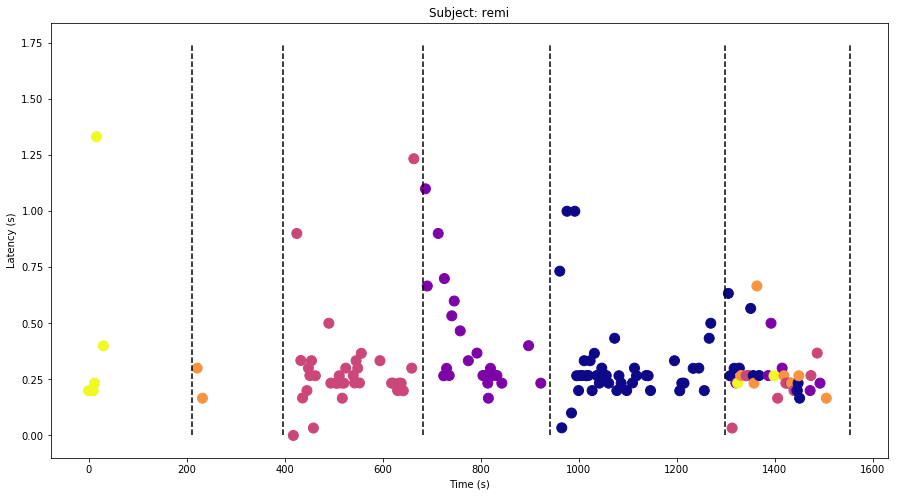

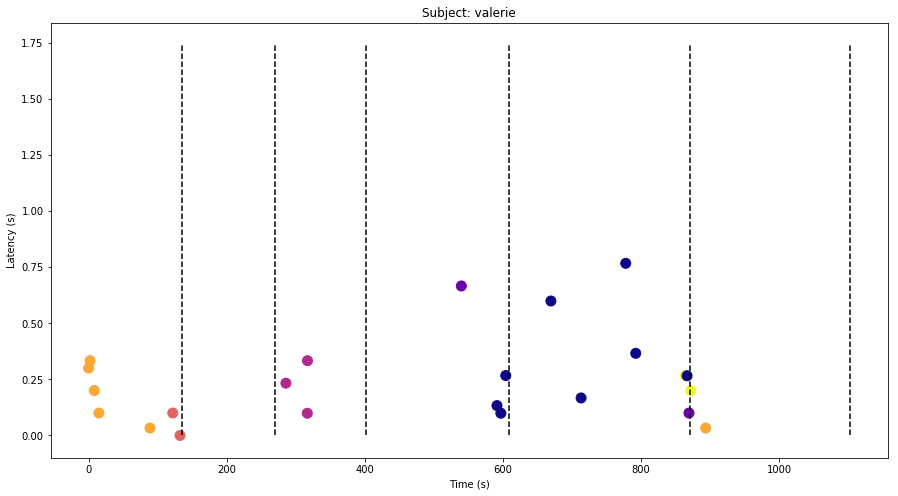

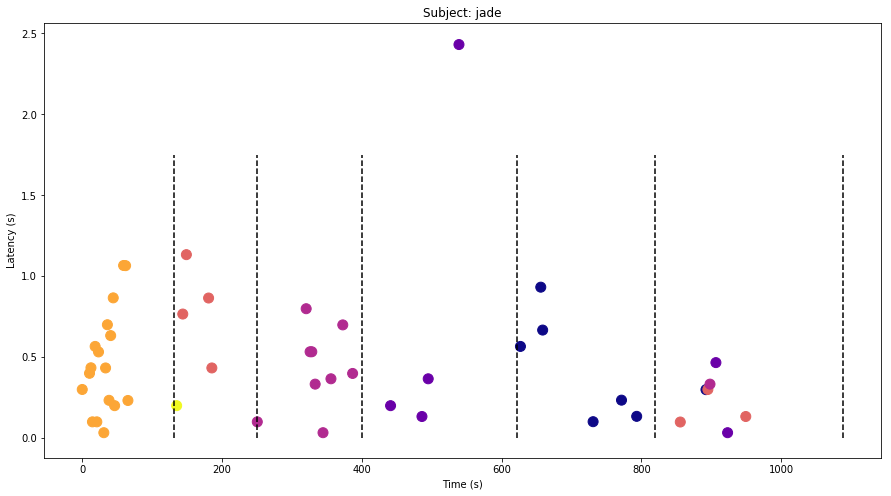

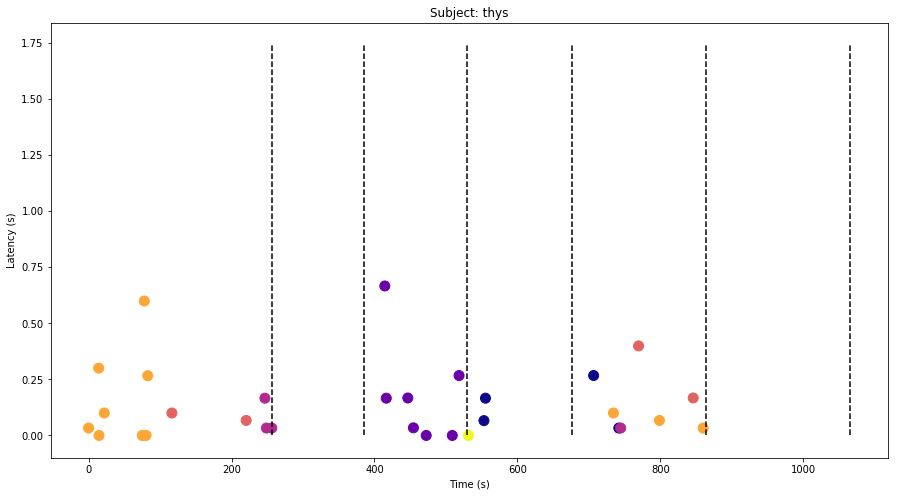

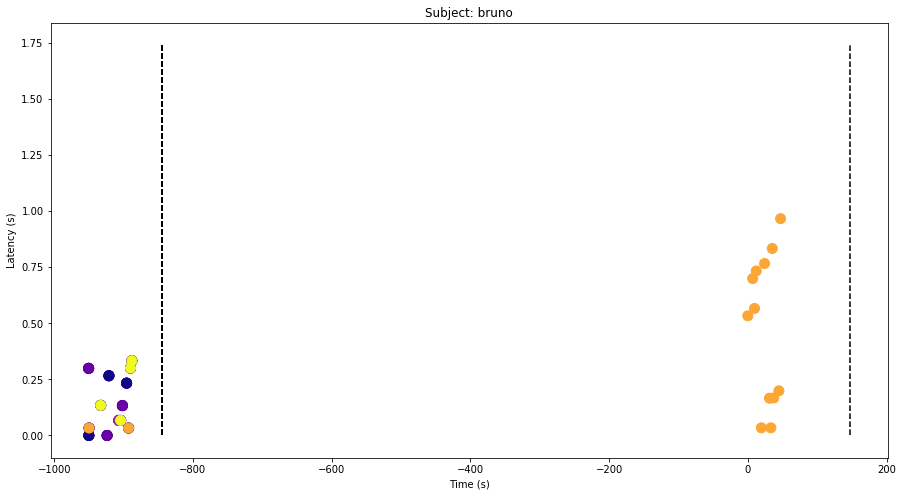

In [10]:
for subj in subjects:
    # Sujets considérés
    if subj in ['remi', 'valerie', 'jade', 'thys', 'bruno']:
        fig, ax = plt.subplots(figsize=(15,8))
        ax.scatter(t_rebound[subj]-t_rebound[subj][0], t_sacc[subj], c=p[subj], s=100, cmap='plasma_r')
        for sep in lvl_sep[subj]:
            ax.plot([sep, sep], [0, 1.75], 'k--')
        ax.set_title('Subject: ' + subj)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Latency (s)')

La cellule ci-dessous trace l'évolution des latences moyennes pour tous les sujets en fonction du niveau du jeu.

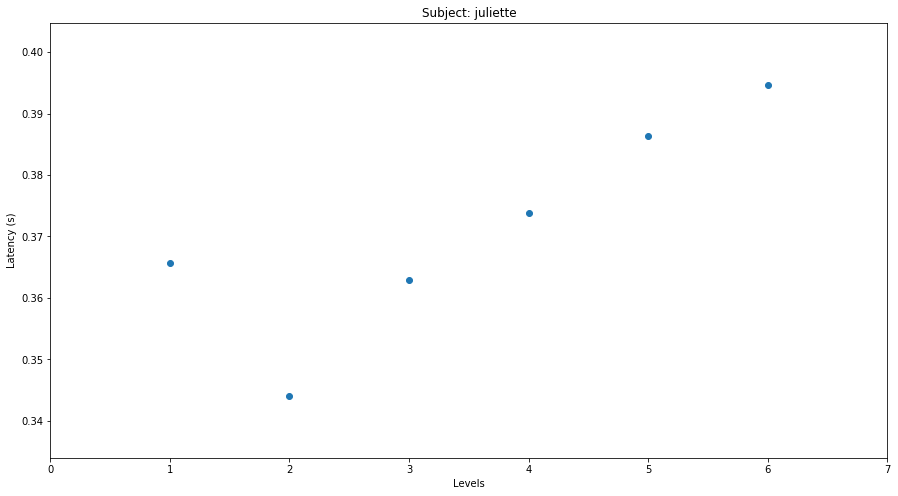

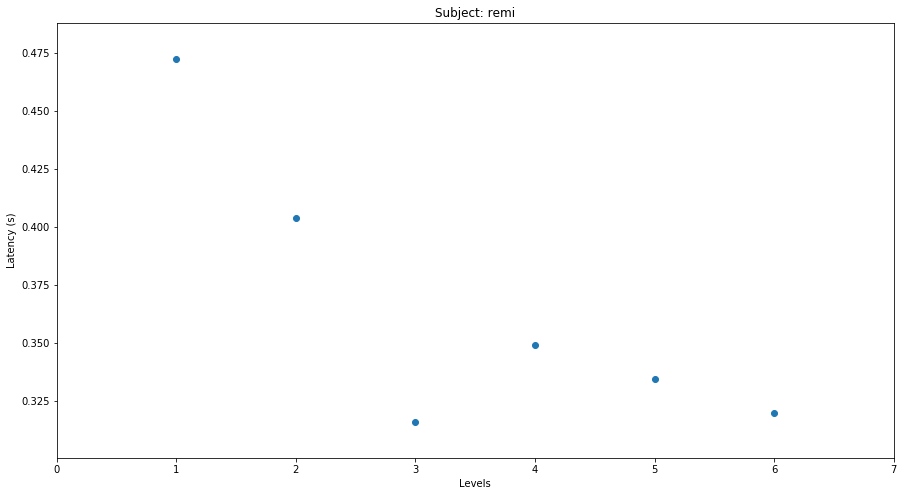

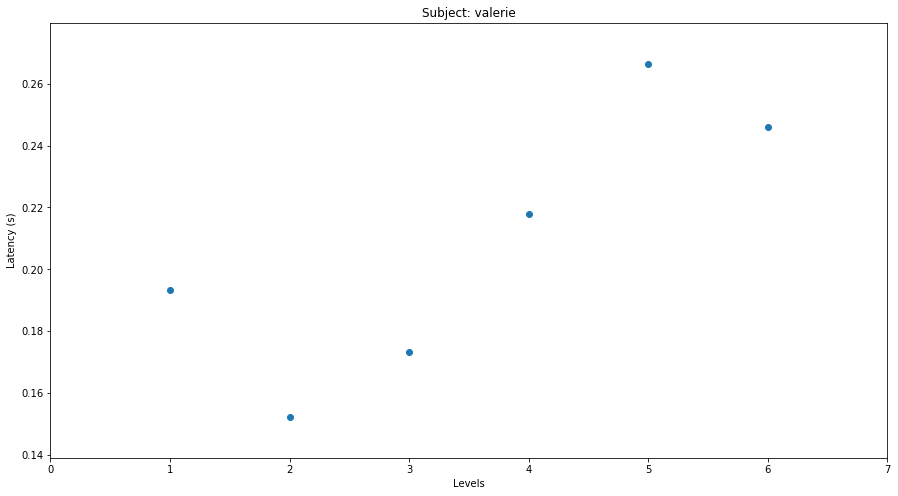

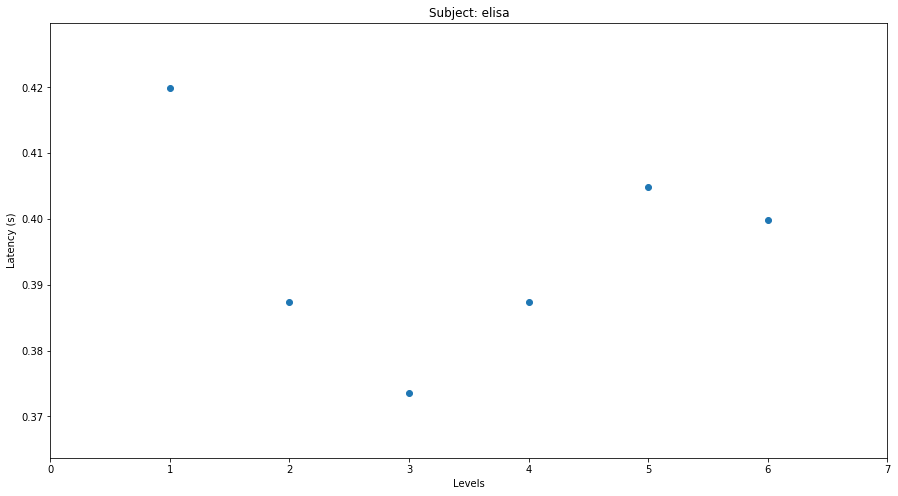

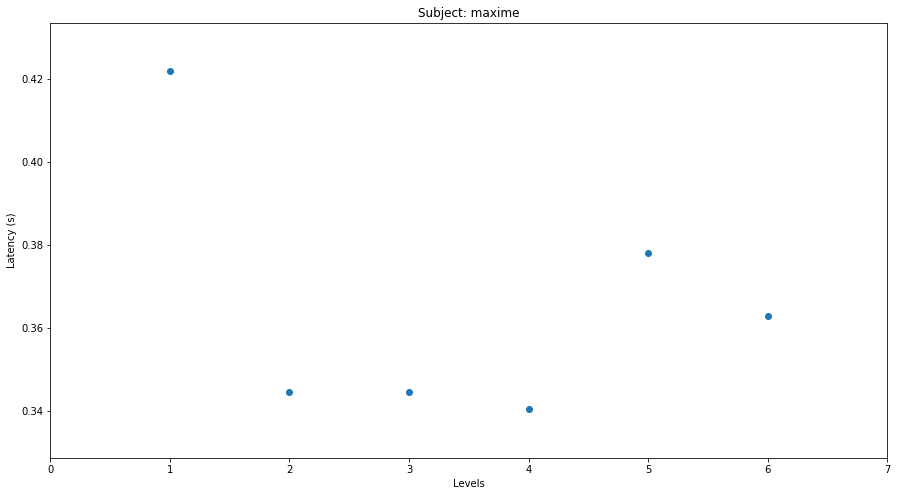

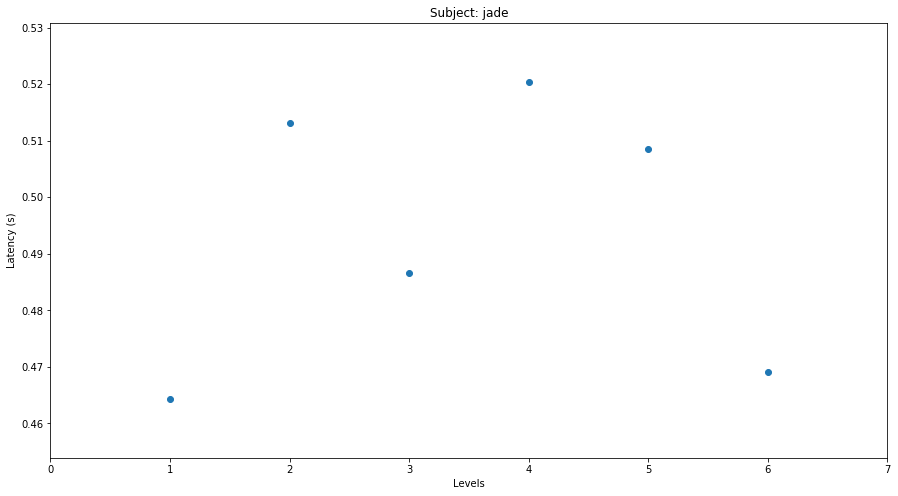

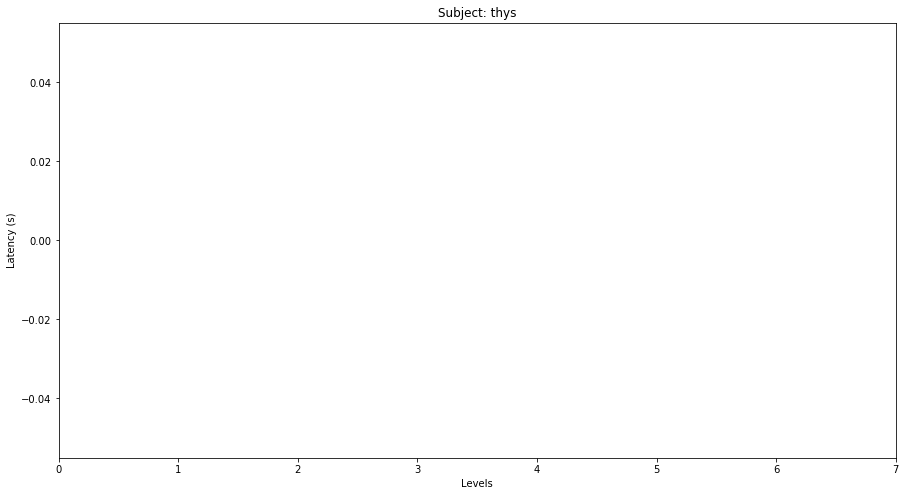

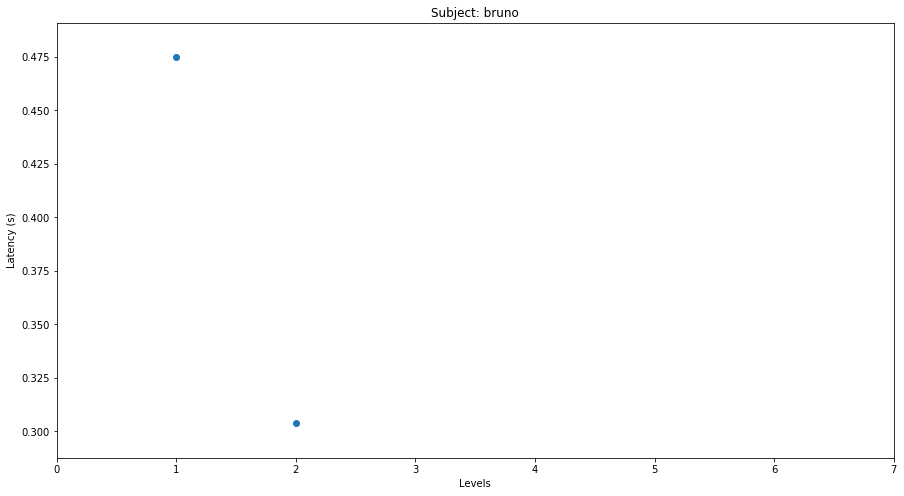

In [20]:
for subj in subjects:
    fig, ax = plt.subplots(figsize=(15,8))
    ax.scatter(lvl[subj], t_mean[subj])
    ax.set_title('Subject: ' + subj)
    ax.set_xlabel('Levels')
    ax.set_ylabel('Latency (s)')
    ax.set_xlim(0, 7)

efe